# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [ ]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
#def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
def download(filename, source='https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)


In [3]:
## new download to get data from my repo
def download(filename):
    url = 'https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main'
    file_url = f'{url}/{filename}'
    cmd = f'wget -O {filename} {file_url}'
    os.system(cmd)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data


Now load in the training set and test set

In [4]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [5]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

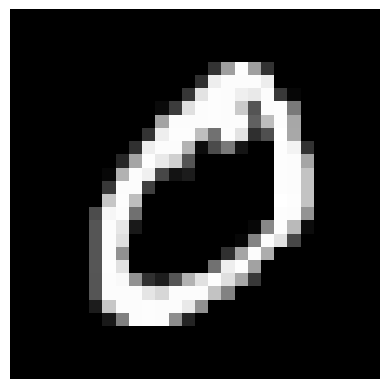

In [6]:
displaychar(train_data[1])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [7]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [ ]:
'''
THIS IS THE FITTING PART
k=10
# Compute log Pr(label|image) for each [test image,label] pair.
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)'''

(60000, 784)


In [ ]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)

    ## normalize data [0,1]
    x = x.astype(np.float32)/255.0

    ## initialize training set and validation set to find best regularization parameter c
    ## note: we will do a 80/20 split of x,y
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=17)

    def calc_priors_means_covariances(x,y,c):
        ## calc priors, means, and covariances
        if c > 0:
            for j in range(k):
                indices = (y==j).flatten()
                x_j = x[indices]
                pi[j] = x_j.shape[0]/x.shape[0]
                mu[j] = np.mean(x_j, axis=0)
                sigma[j] = np.cov(x_j.T) + c*np.eye(d)
        else:
            for j in range(k):
                indices = (y==j).flatten()
                x_j = x[indices]
                pi[j] = x_j.shape[0]/x.shape[0]
                mu[j] = np.mean(x_j, axis=0)
                sigma[j] = np.cov(x_j.T) 
        return mu, sigma, pi

    ## evaluate c using multivariate normal distribution to the training set and validation set
    def fit(x_train,y_train,x_val,y_val,c):
        print(f'calculating mu, sigma, pi for c: {c}')
        mu, sigma, pi = calc_priors_means_covariances(x_train,y_train,c)
        score = np.zeros((len(x_val),k))
        print(f'calc score for c: {c}')
        for label in range(0,k):
            rv = multivariate_normal(mean=mu[label], cov=sigma[label],allow_singular=True)
            score[:,label] = np.log(pi[label]) + rv.logpdf(x_val[:,:])
            #for i in range(0,len(x_val)):
                #score[i,label] = np.log(pi[label]) + rv.logpdf(x_val[i,:])
        predictions = np.argmax(score, axis=1)
        errors = np.sum(predictions != y_val)
        print(f'c: {c}, errors: {errors}')
        return errors

    ## find best c
    def find_best_c():
        ## initialize c values to test and an empty list to store errors
        c_values = [0,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
        errors = []
        ## loop through c values and calculate error
        for c in c_values:
            print("Calculating error for c: ", c)
            error = fit(x_train,y_train,x_val,y_val,c)
            errors.append(error)
            print("c: ", c, " error: ", error)
            c_error_dict['c_value'].append(c)
            c_error_dict['error'].append(error)
        ## find best c where error is minimum
        best_c = c_values[np.argmin(errors)]

        return best_c

    ## calculate best c
    best_c, c_error_dict = find_best_c()
    
    ## calc mu, sigma, pi using best c
    mu, sigma, pi = calc_priors_means_covariances(x,y,best_c)

    # Halt and return parameters
    return mu, sigma, pi

Calculating error for c:  0
calculating mu, sigma, pi for c: 0
calc score for c: 0
c: 0, errors: 9119
c:  0  error:  9119
Calculating error for c:  0.0001
calculating mu, sigma, pi for c: 0.0001
calc score for c: 0.0001
c: 0.0001, errors: 1647
c:  0.0001  error:  1647
Calculating error for c:  0.001
calculating mu, sigma, pi for c: 0.001
calc score for c: 0.001
c: 0.001, errors: 1171
c:  0.001  error:  1171
Calculating error for c:  0.01
calculating mu, sigma, pi for c: 0.01
calc score for c: 0.01
c: 0.01, errors: 695
c:  0.01  error:  695
Calculating error for c:  0.1
calculating mu, sigma, pi for c: 0.1
calc score for c: 0.1
c: 0.1, errors: 608
c:  0.1  error:  608
Calculating error for c:  1
calculating mu, sigma, pi for c: 1
calc score for c: 1
c: 1, errors: 1482
c:  1  error:  1482
Calculating error for c:  10
calculating mu, sigma, pi for c: 10
calc score for c: 10
c: 10, errors: 3837
c:  10  error:  3837
Calculating error for c:  100
calculating mu, sigma, pi for c: 100
calc sco

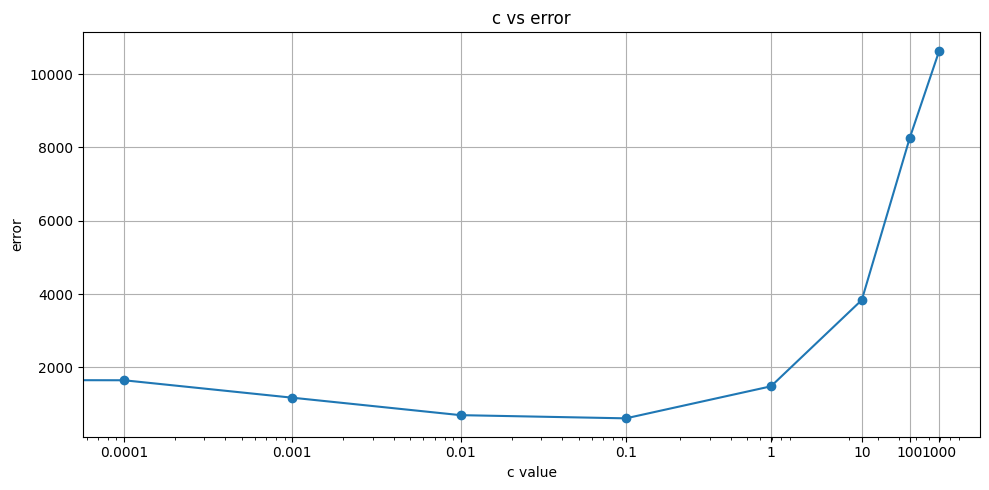

mu:  (10, 784)
sigma:  (10, 784, 784)
pi:  (10,)


In [19]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)

    ## normalize data [0,1]
    x = x.astype(np.float32)/255.0

    ## initalize training set and validation set to find best regularization parameter c
    ## note: we will do a 80/20 split of x,y
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=17)

    def calc_priors_means_covariances(x,y,c):
        ## calc priors, means, and covariances
        if c > 0:
            for j in range(k):
                indices = (y==j).flatten()
                x_j = x[indices]
                pi[j] = x_j.shape[0]/x.shape[0]
                mu[j] = np.mean(x_j, axis=0)
                sigma[j] = np.cov(x_j.T) + c*np.eye(d)
        else:
            for j in range(k):
                indices = (y==j).flatten()
                x_j = x[indices]
                pi[j] = x_j.shape[0]/x.shape[0]
                mu[j] = np.mean(x_j, axis=0)
                sigma[j] = np.cov(x_j.T) 
        return mu, sigma, pi

    ## evaluate c using multivariate normal distribution to the training set and validation set
    def fit(x_train,y_train,x_val,y_val,c):
        print(f'calculating mu, sigma, pi for c: {c}')
        mu, sigma, pi = calc_priors_means_covariances(x_train,y_train,c)
        score = np.zeros((len(x_val),k))
        print(f'calc score for c: {c}')
        for label in range(0,k):
            rv = multivariate_normal(mean=mu[label], cov=sigma[label],allow_singular=True)
            score[:,label] = np.log(pi[label]) + rv.logpdf(x_val[:,:])
            #for i in range(0,len(x_val)):
                #score[i,label] = np.log(pi[label]) + rv.logpdf(x_val[i,:])
        predictions = np.argmax(score, axis=1)
        errors = np.sum(predictions != y_val)
        print(f'c: {c}, errors: {errors}')
        return errors

    ## find best c
    def find_best_c():
        ## initialize c values to test and an empty list to store errors
        c_values = [0,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
        errors = []

        ## initialize dictionary to store errors (i.e., c_value:[], error:[])
        c_error_dict = {'c_value':[], 'error':[]}
        for c in c_values:
            print("Calculating error for c: ", c)
            error = fit(x_train,y_train,x_val,y_val,c)
            errors.append(error)
            print("c: ", c, " error: ", error)
            c_error_dict['c_value'].append(c)
            c_error_dict['error'].append(error)

        best_c = c_values[np.argmin(errors)]
        print("Best c value: ", best_c)
        return best_c, c_error_dict

    ## plot c vs error
    def plot_c_vs_error(c_error_dict):
        plt.figure(figsize=(10, 5))
        plt.title('c vs error')
        plt.xlabel('c value')
        plt.ylabel('error')
        plt.xscale('log')
        plt.xticks(ticks=np.log1p(c_error_dict['c_value']), labels=[str(i) for i in c_error_dict['c_value']])
        plt.grid()
        plt.plot(np.log1p(c_error_dict['c_value']), c_error_dict['error'], marker='o', linestyle='-')
        plt.tight_layout()
        plt.show()

    ## calculate best c
    best_c, c_error_dict = find_best_c()
    
    ## plot c vs error
    plot_c_vs_error(c_error_dict)

    ## calc mu, sigma, pi using best c
    mu, sigma, pi = calc_priors_means_covariances(x,y,best_c)

    # Halt and return parameters
    return mu, sigma, pi

mu, sigma, pi = fit_generative_model(train_data, train_labels)
print("mu: ", mu.shape)
print("sigma: ", sigma.shape)
print("pi: ", pi.shape)

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

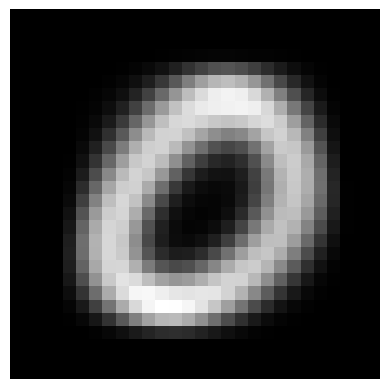

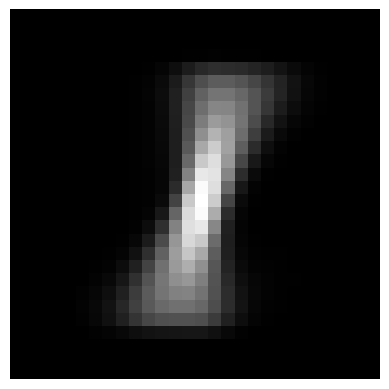

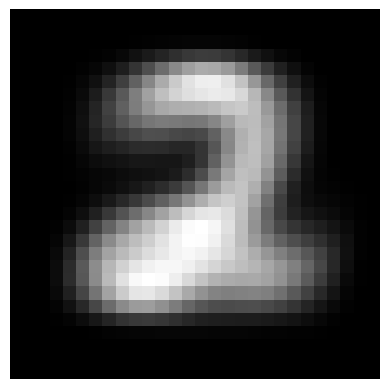

In [11]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)

displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [21]:
k=10
# Compute log Pr(label|image) for each [test image,label] pair.
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    score[:,label] = np.log(pi[label]) + rv.logpdf(test_data[:,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 577 errors out of 10000


predicted label: 8
actual label: 1


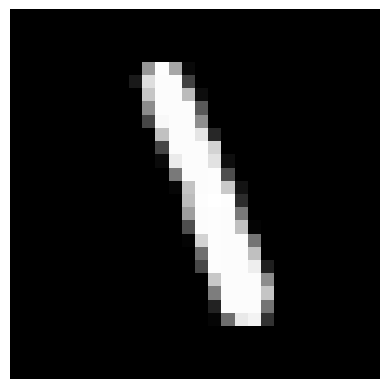

predicted label: 7
actual label: 9


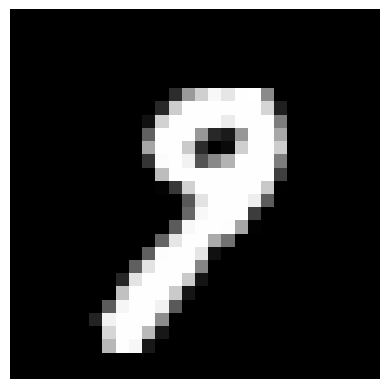

predicted label: 8
actual label: 9


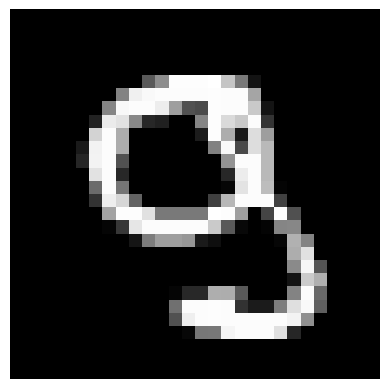

predicted label: 8
actual label: 9


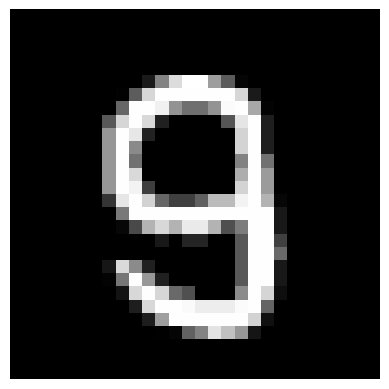

predicted label: 7
actual label: 2


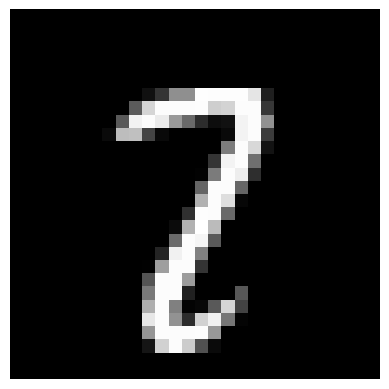

In [25]:
error_data = test_data[predictions != test_labels]
error_labels = test_labels[predictions != test_labels]
error_predictions = predictions[predictions != test_labels]
for i in range(5):
    print(f'predicted label: {error_predictions[i*i]}')
    print(f'actual label: {error_labels[i*i]}')
    displaychar(error_data[i*i])

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?



<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?